# Solution for P1 - Finding Lane Lines

Showing pipeline for image test_images/solidWhiteCurve.jpg


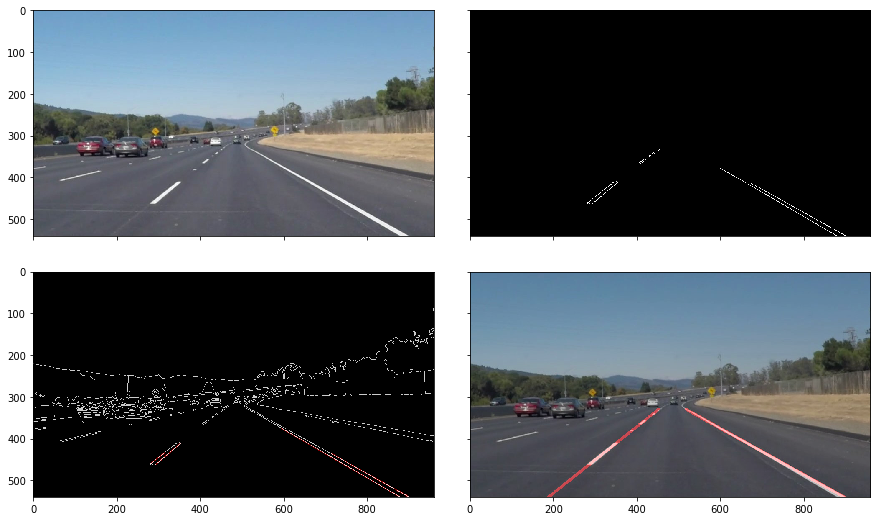

Showing pipeline for image test_images/solidWhiteRight.jpg


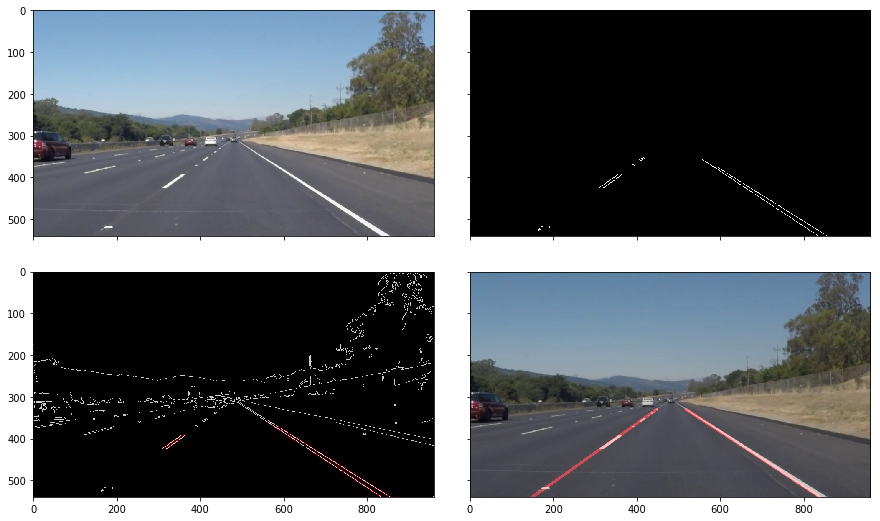

Showing pipeline for image test_images/solidYellowCurve.jpg


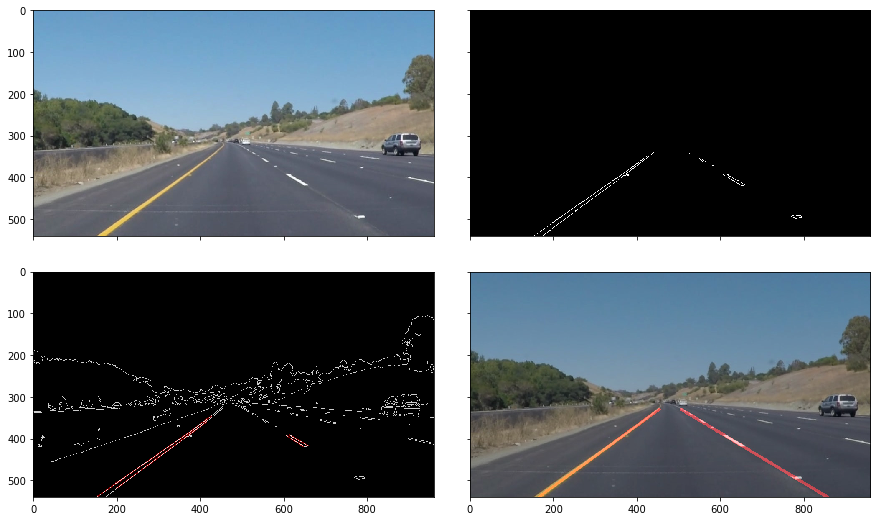

Showing pipeline for image test_images/solidYellowCurve2.jpg


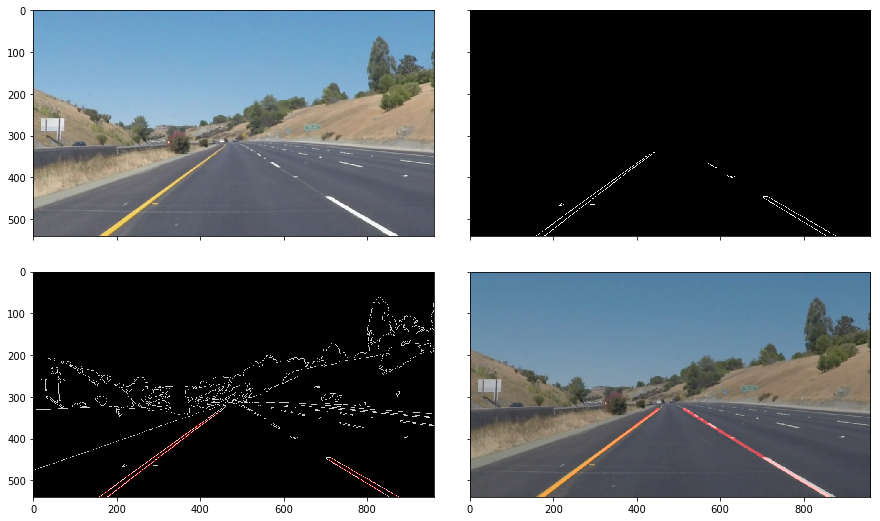

Showing pipeline for image test_images/solidYellowLeft.jpg


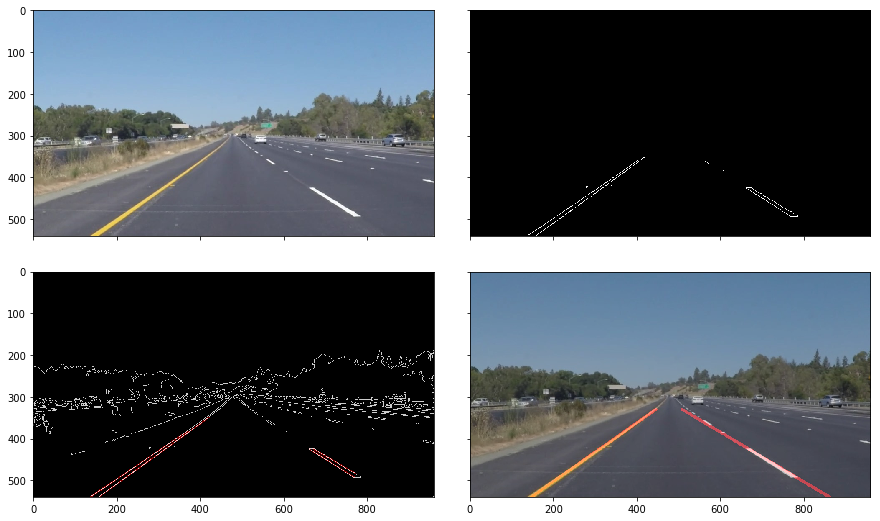

Showing pipeline for image test_images/whiteCarLaneSwitch.jpg


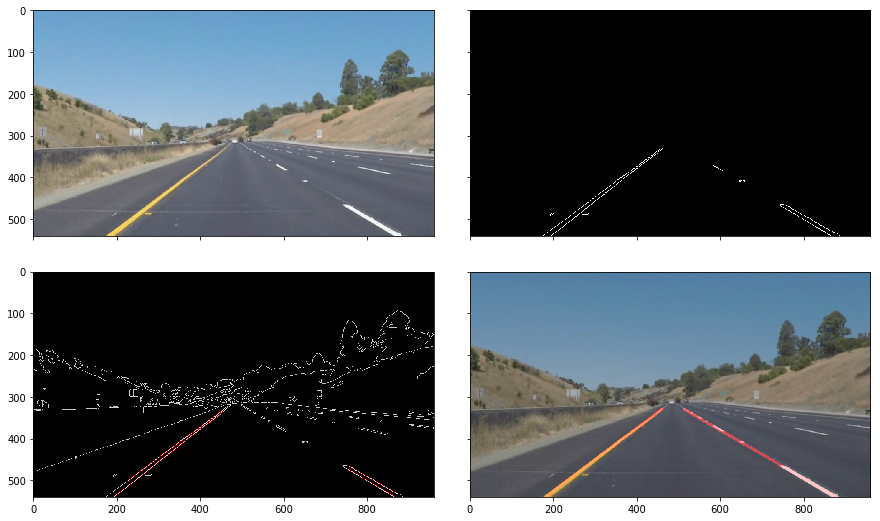

In [60]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from mpl_toolkits.axes_grid1 import ImageGrid
from helper_functions import *

fig_idx = 0

for file in [f for f in os.listdir('test_images') if f.endswith('.jpg')]:
    
    test_image_filename = os.path.join('test_images', file)
    print('Showing pipeline for image ' + test_image_filename)
    test_image = mpimg.imread(test_image_filename)
    gray_image = grayscale(test_image)
    gausblur_image = gaussian_blur(gray_image, 3)
    canny_image = canny(gausblur_image, 50, 150)

    imshape = canny_image.shape
    vertices = np.array([[(30,imshape[0]),(460, 330), (500, 330), (930,imshape[0])]], dtype=np.int32)
    roi_image = region_of_interest(canny_image, vertices)

    rho = 3
    theta = 2*np.pi/180
    threshold = 100
    min_line_len = 20; max_line_gap = 10
    image_lines, lines = hough_lines(roi_image, rho, theta, threshold, min_line_len, max_line_gap)

    color_canny = np.dstack((canny_image, canny_image, canny_image))
    lines_over_canny = weighted_img(image_lines, color_canny, 0.8, .5, 0.)
    lines_over_image = weighted_img(image_lines, test_image, 0.8, .5, 0.)
    
    pos_skews = []; r_lane_offset = [];
    neg_skews = []; l_lane_offset = [];
    for line in lines:
        for x1,y1,x2,y2 in line:
            A = np.vstack([(x1, x2),np.ones(2)]).T
            skew, offset = np.linalg.lstsq(A, (y1, y2))[0]
            if skew > 0:
                pos_skews.append(skew)
                r_lane_offset.append(offset)
            elif skew < 0:
                neg_skews.append(skew)
                l_lane_offset.append(offset)

    l_lane_avg_skew = np.mean(neg_skews)
    l_lane_avg_offset = np.mean(l_lane_offset)
    l_lane_x_0 = (imshape[0]-l_lane_avg_offset)/l_lane_avg_skew
    l_lane_x_1 = (330-l_lane_avg_offset)/l_lane_avg_skew
    r_lane_avg_skew = np.mean(pos_skews)
    r_lane_avg_offset = np.mean(r_lane_offset)
    r_lane_x_0 = (imshape[0]-r_lane_avg_offset)/r_lane_avg_skew
    r_lane_x_1 = (330-r_lane_avg_offset)/r_lane_avg_skew
    
    canvas = np.zeros_like(test_image)
    lane_lines = np.array([[[l_lane_x_0, imshape[0], l_lane_x_1, 330]], \
                          [[r_lane_x_0, imshape[0], r_lane_x_1, 330]]], np.int32)
    draw_lines(canvas, lane_lines, thickness=6)
    lane_lines_over_image = weighted_img(canvas, test_image, 0.8, .5, 0.)
    
    fig_idx += 1;
    fig = plt.figure(fig_idx, (15., 10.))
    grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=.5)
    grid[0].imshow(test_image)
    grid[1].imshow(roi_image, cmap='gray')
    grid[2].imshow(lines_over_canny)
    grid[3].imshow(lane_lines_over_image)
    plt.show()